In [12]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping


### Import Data

In [13]:
import pandas as pd

petrignano_df = pd.read_csv('/workspaces/time-series-project-tutorial/acea-water-prediction/Aquifer_Petrignano.csv')
petrignano_df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [14]:
petrignano_df.isnull().sum()
petrignano_df = petrignano_df.dropna()
print(petrignano_df)

            Date  Rainfall_Bastia_Umbra  Depth_to_Groundwater_P24  \
1024  01/01/2009                    0.0                    -31.96   
1025  02/01/2009                    0.0                    -32.03   
1026  03/01/2009                    0.0                    -31.97   
1027  04/01/2009                    0.0                    -31.91   
1028  05/01/2009                    0.0                    -31.94   
...          ...                    ...                       ...   
5218  26/06/2020                    0.0                    -25.68   
5219  27/06/2020                    0.0                    -25.80   
5220  28/06/2020                    0.0                    -25.80   
5221  29/06/2020                    0.0                    -25.78   
5222  30/06/2020                    0.0                    -25.91   

      Depth_to_Groundwater_P25  Temperature_Bastia_Umbra  \
1024                    -31.14                       5.2   
1025                    -31.11                     

### Format Time Series Date Field

In [15]:
from datetime import datetime

original_date = petrignano_df['Date']
parsed_date = original_date.apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))

# Format to mm/dd/yyyy
petrignano_df['formatted_date'] = pd.to_datetime(petrignano_df['Date'], format="%d/%m/%Y").dt.strftime("%m/%d/%Y")

print(petrignano_df['formatted_date'])


1024    01/01/2009
1025    01/02/2009
1026    01/03/2009
1027    01/04/2009
1028    01/05/2009
           ...    
5218    06/26/2020
5219    06/27/2020
5220    06/28/2020
5221    06/29/2020
5222    06/30/2020
Name: formatted_date, Length: 4150, dtype: object


In [16]:
petrignano_df = petrignano_df.set_index('formatted_date')
petrignano_df = petrignano_df.drop(columns=['Date'])
petrignano_df.head()

,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
formatted_date,,,,,,,
01/01/2009,0.0,-31.96,-31.14,5.2,4.9,-24530.688,2.4
01/02/2009,0.0,-32.03,-31.11,2.3,2.5,-28785.888,2.5
01/03/2009,0.0,-31.97,-31.07,4.4,3.9,-25766.208,2.4
01/04/2009,0.0,-31.91,-31.05,0.8,0.8,-27919.296,2.4
01/05/2009,0.0,-31.94,-31.01,-1.9,-2.1,-29854.656,2.3


In [17]:
petrignano_df.columns

Index(['Rainfall_Bastia_Umbra', 'Depth_to_Groundwater_P24',
       'Depth_to_Groundwater_P25', 'Temperature_Bastia_Umbra',
       'Temperature_Petrignano', 'Volume_C10_Petrignano',
       'Hydrometry_Fiume_Chiascio_Petrignano'],
      dtype='object')

## Multivariate Analysis - LSTM 

### Min Max Scaling

#### Function to Min Max scale multiple features

In [18]:
target_columns = petrignano_df[['Depth_to_Groundwater_P24', 'Depth_to_Groundwater_P25']].columns.tolist()
feature_columns = petrignano_df.drop(columns=target_columns).columns.tolist()

#target_columns.dtypes

In [19]:
# Ensure X is defined

def prepare_multi_feature_data(df, feature_columns, target_columns, lookback=30):
    """
    Prepare multi-feature sequences for LSTM model
    """
    
    X, y = [], []
    # Scale the features
    scaler_features = MinMaxScaler()
    scaled_features = scaler_features.fit_transform(df[feature_columns])
    
    # Scale the target separately
    scaler_target = MinMaxScaler()
    scaled_target = scaler_target.fit_transform(df[target_columns])
    
    for i in range(len(df) - lookback):
        # Features: take all feature columns for the lookback period
        X.append(scaled_features[i:(i + lookback)])
        # Targets: take all target columns for the prediction point
        y.append(scaled_target[(i + lookback)])
    
    return X, y, scaler_features, scaler_target

# Call the function with debugging
try:
    X, y, scaler_features, scaler_target = prepare_multi_feature_data(petrignano_df, feature_columns, target_columns, lookback=30)
    print(scaler_target)
except ValueError as e:
    print("ValueError encountered:", e)
    # print("petrignano_df shape:", petrignano_df.shape)
    # print("feature_columns:", feature_columns)
    # print("target_columns:", target_columns)
    # print("lookback:", 7)





MinMaxScaler()


#### Define Test Train Split Myself <br>

In [20]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
test_size = len(X) - train_size
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
#print(y_train)


Train size: 3296, Test size: 824


### LSTM Model Multi-Target

In [21]:
from tensorflow.keras.layers import Bidirectional

n_features = len(feature_columns)

model = Sequential([
    # Increase capacity for better pattern recognition
    Bidirectional(LSTM(256, return_sequences=True, input_shape=(30, n_features))),
    Dropout(0.1),
    
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.1),
    
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.1),
    
    Bidirectional(LSTM(32)),
    Dropout(0.1),
    
    Dense(32, activation='relu'),
    Dense(2)
])

# Use Huber loss to handle outliers better
model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)


In [23]:
# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

# Ensure the shapes are compatible
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # Use 20% of the training data for validation
    epochs=100,            # Set a high number of epochs; early stopping will stop it earlier if needed
    batch_size=32,         # Adjust batch size based on your dataset size
    callbacks=[early_stopping],
    verbose=1              # Print training progress
)

X_train shape: (3296, 30, 5)
y_train shape: (3296, 2)
Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 35s 315ms/step - loss: 0.0564 - val_loss: 0.0142
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 319ms/step - loss: 0.0212 - val_loss: 0.0059
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 330ms/step - loss: 0.0193 - val_loss: 0.0172
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 38s 297ms/step - loss: 0.0174 - val_loss: 0.0075
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 25s 306ms/step - loss: 0.0164 - val_loss: 0.0153
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 307ms/step - loss: 0.0151 - val_loss: 0.0079
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 335ms/step - loss: 0.0145 - val_loss: 0.0135


In [24]:
import numpy as np

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

# Ensure the shapes are compatible
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Recompile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='huber')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

X_train shape: (3296, 30, 5)
y_train shape: (3296, 2)
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 306ms/step - loss: 0.0181 - val_loss: 0.0114
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 29s 312ms/step - loss: 0.0160 - val_loss: 0.0143
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 40s 306ms/step - loss: 0.0151 - val_loss: 0.0127
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 40s 299ms/step - loss: 0.0135 - val_loss: 0.0278
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 300ms/step - loss: 0.0135 - val_loss: 0.0168
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 40s 290ms/step - loss: 0.0135 - val_loss: 0.0177
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 27s 293ms/step - loss: 0.0125 - val_loss: 0.0192
Epoch 8/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 308ms/step - loss: 0.0109 - val_loss: 0.0263
Epoch 9/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 40s 303ms/step - loss: 0.0113 - val_loss: 0.0214
Epoch 10/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 46s 354ms/step - loss: 0.0114 - val_loss: 0.0288
Epoch 11/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 45s 396ms/step - loss: 0.0117 - val_

### Model Predictions
We train the model on the train data and the test data to see how well <br>
we are predicting the training and testing data

In [25]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print(test_pred)

103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step
[[0.878392   0.8849378 ]
 [0.8560405  0.8627182 ]
 [0.8490479  0.8558034 ]
 ...
 [0.78466547 0.77995926]
 [0.7875495  0.7871854 ]
 [0.7943196  0.7894789 ]]


### Convert back to normal scale

In [26]:
# Inverse transform predictions
train_pred = scaler_target.inverse_transform(train_pred)
test_pred = scaler_target.inverse_transform(test_pred)
y_train_orig = scaler_target.inverse_transform(y_train)
y_test_orig = scaler_target.inverse_transform(y_test)



### Evaluate Loss

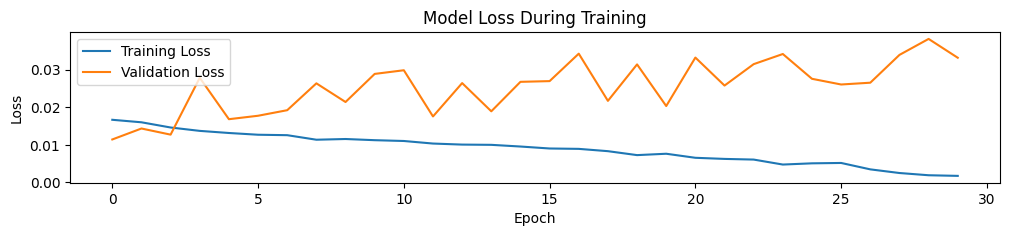

In [27]:
import matplotlib.pyplot as plt


# Create visualizations
plt.figure(figsize=(12, 9))

# Plot 1: Training Loss
plt.subplot(4, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Evaluate Progress

In [28]:
def evaluate_regression_lstm(y_true, y_pred):
    # R² score (1.0 is perfect prediction)
    r2 = r2_score(y_true, y_pred)
    
    # Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)
    
    # Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Custom accuracy metric for regression (as percentage)
    # Using 1 - normalized MAE as a proxy for accuracy
    #accuracy = (1 - mae / (y_true.max() - y_true.min())) * 100
    
    print("\nRegression Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    #print(f"Accuracy (based on normalized MAE): {accuracy:.2f}%")
    
    return r2, mae, rmse

In [29]:
evaluate_regression_lstm(y_test_orig, test_pred)


Regression Metrics:
R² Score: -7.0516
MAE: 2.1194
RMSE: 2.4347


(-7.0515572785039, 2.1193840258329812, 2.434731901449372)

## Plot Residuals - Actual vs Predicted

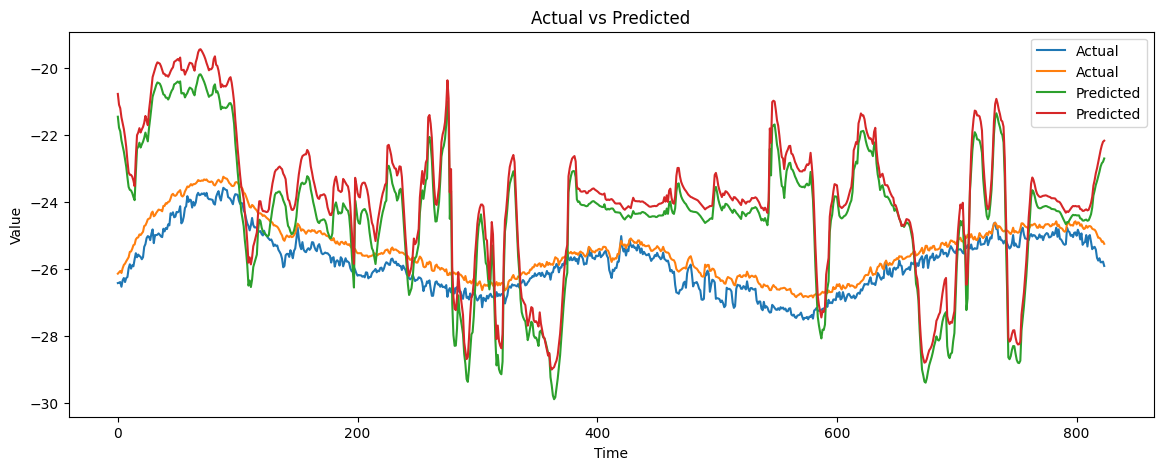

In [30]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs Predicted'):
    plt.figure(figsize=(14, 5))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Assuming y_test and test_pred are defined
plot_actual_vs_predicted(y_test_orig, test_pred)

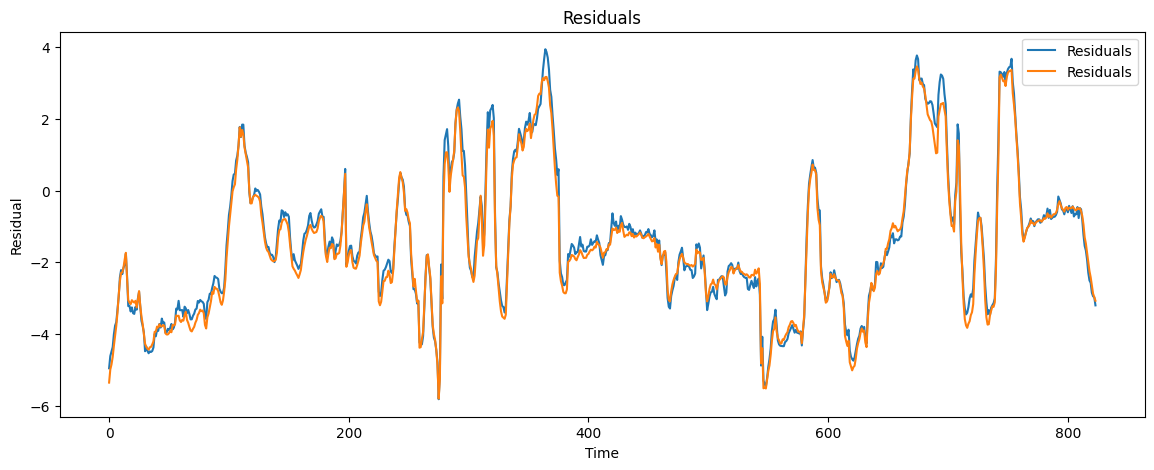

In [31]:
def plot_residuals(y_true, y_pred, title='Residuals'):
    residuals = y_true - y_pred
    plt.figure(figsize=(14, 5))
    plt.plot(residuals, label='Residuals')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.legend()
    plt.show()
    
    
plot_residuals(y_test_orig, test_pred, title='Residuals')

In [32]:
# def find_optimal_lr(model, X_train, y_train):
#     lr_schedule = np.logspace(-4, -2, 100)  # Test from 0.0001 to 0.01
#     losses = []
    
#     for lr in lr_schedule:
#         model.optimizer.learning_rate.assign(lr)
#         loss = model.train_on_batch(X_train[:32], y_train[:32])
#         losses.append(loss)
        
#     best_lr = lr_schedule[np.argmin(losses)]
#     return best_lr

# find_optimal_lr(model, X_train, y_train)